In [136]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import TimeSeriesSplit

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt 
import matplotlib.dates as mdates

import plotly.io as pio
import plotly.express as px

import plotly.graph_objs as go
import seaborn as sns


from walmart_utils.download import download_dataset
from walmart_utils.merge_data import merge_data, dedupe
from walmart_utils.feature_engineering import (
    add_calendar_features, sum_markdown, add_holiday,
    add_memory_feature
)
from walmart_utils.exploratory_analysis import view_data_horizon
from walmart_utils.pipeline import GlobalPipeline
from walmart_utils.models import models
from walmart_utils.training import evaluate_models, plot_errors


In [137]:
zip_path = "./walmart-recruiting-store-sales-forecasting.zip"
extract_dir = "./walmart_dataset"
features_df, stores_df, test_df, train_df = download_dataset()

El archivo ./walmart-recruiting-store-sales-forecasting.zip no existe.
El archivo ./walmart_dataset/features.csv.zip no existe.
El archivo ./walmart_dataset/sampleSubmission.csv.zip no existe.
El archivo ./walmart_dataset/test.csv.zip no existe.
El archivo ./walmart_dataset/train.csv.zip no existe.
dataset descargado con éxito :)
dataset formateado :)


In [138]:
view_data_horizon(train_df, target="Weekly_Sales", store=10, dept=11, back_horizon=52)

In [139]:
unique_stores = train_df["Store"].unique()
unique_depts = train_df["Dept"].unique()

print("stores:", unique_stores.__len__())
print("departments:", unique_depts.__len__())

stores: 45
departments: 81


In [140]:
train_df.sort_values(by=['Store', 'Dept', 'Date'], inplace=True)

In [141]:
# # Histograma de ventas
# plt.figure(figsize=(10,6))
# plt.hist(train_df['Weekly_Sales'], bins=50, edgecolor='black')
# plt.title('Distribución de Ventas Diarias')
# plt.xlabel('Ventas')
# plt.ylabel('Frecuencia')
# plt.show()

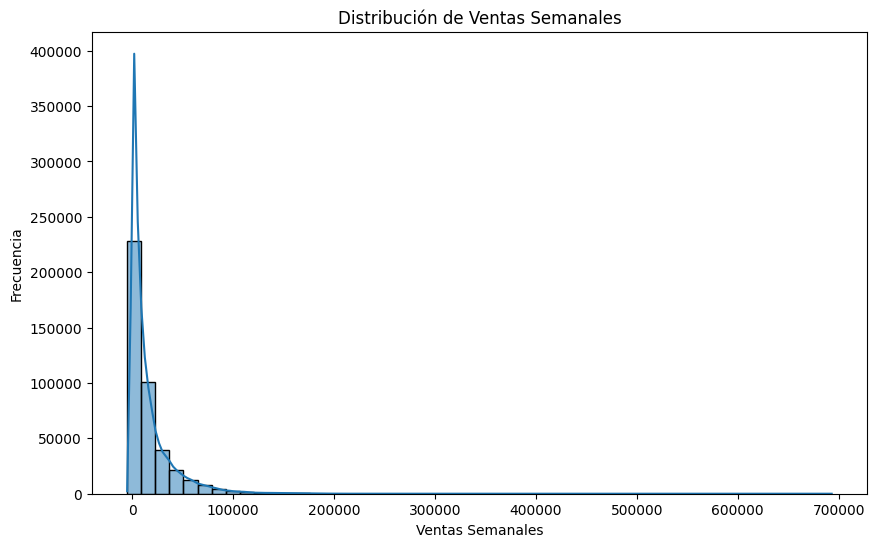

In [142]:
plt.figure(figsize=(10,6))
sns.histplot(train_df['Weekly_Sales'], bins=50, kde=True)
plt.title('Distribución de Ventas Semanales')
plt.xlabel('Ventas Semanales')
plt.ylabel('Frecuencia')
plt.show()

<Figure size 1000x600 with 0 Axes>

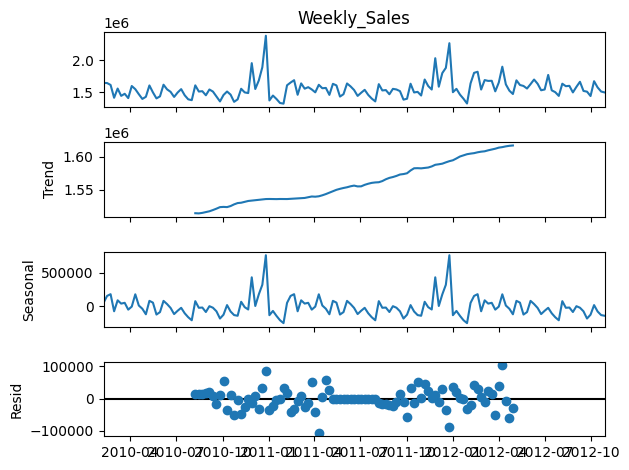

In [143]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Filtrar datos de una tienda específica
plt.figure(figsize=(10,6))
df_store = train_df[train_df['Store'] == 1]
df_store.set_index('Date', inplace=True)
sales_series = df_store['Weekly_Sales'].resample('W').sum()

decomposition = seasonal_decompose(sales_series, model='additive')
decomposition.plot()
plt.show()


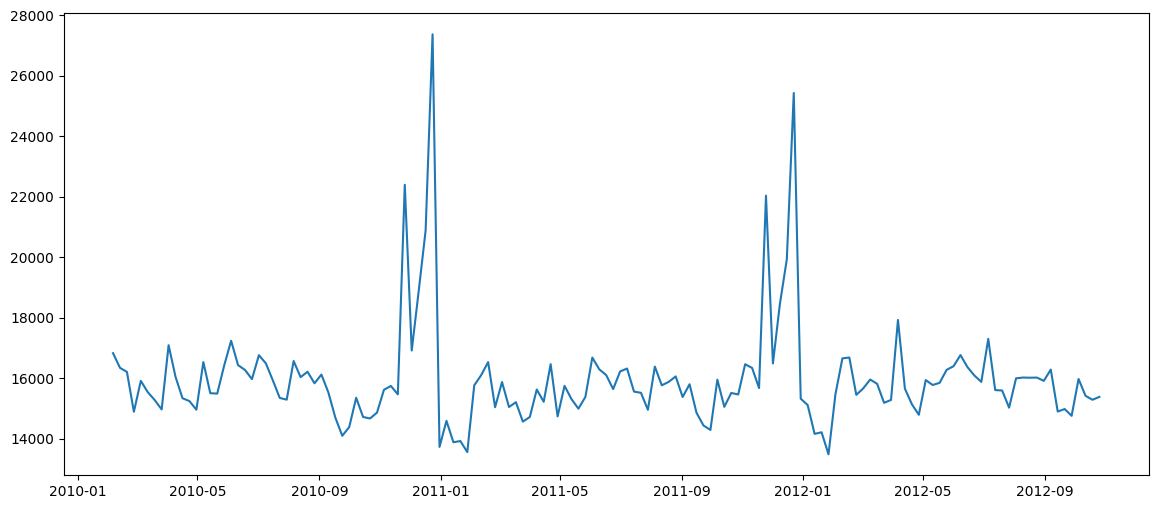

In [144]:
df = train_df.groupby(["Date"]).mean().reset_index()
df.sort_values("Date", ascending=True ,inplace=True)
plt.figure(figsize=(14,6))
plt.plot(df['Date'], df['Weekly_Sales'])


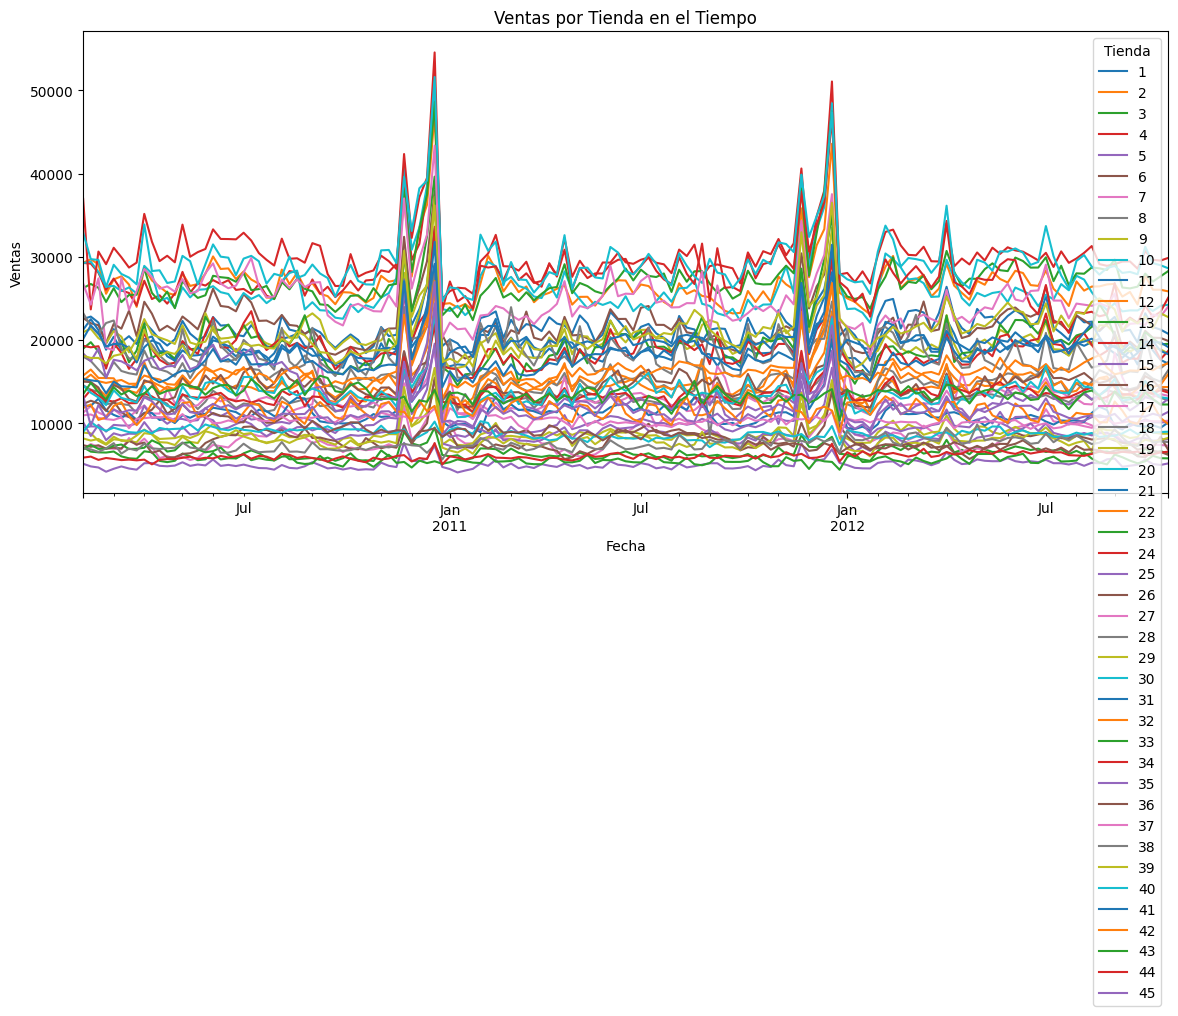

In [145]:
# Agregar ventas por fecha y tienda
ventas_tienda = train_df.groupby(['Date', 'Store'])['Weekly_Sales'].mean().reset_index()

# Crear una tabla pivote para graficar
ventas_tienda_pivot = ventas_tienda.pivot(index='Date', columns='Store', values='Weekly_Sales')

# Graficar ventas por tienda
ventas_tienda_pivot.plot(figsize=(14,6))
plt.title('Ventas por Tienda en el Tiempo')
plt.xlabel('Fecha')
plt.ylabel('Ventas')
plt.legend(title='Tienda')
plt.show()


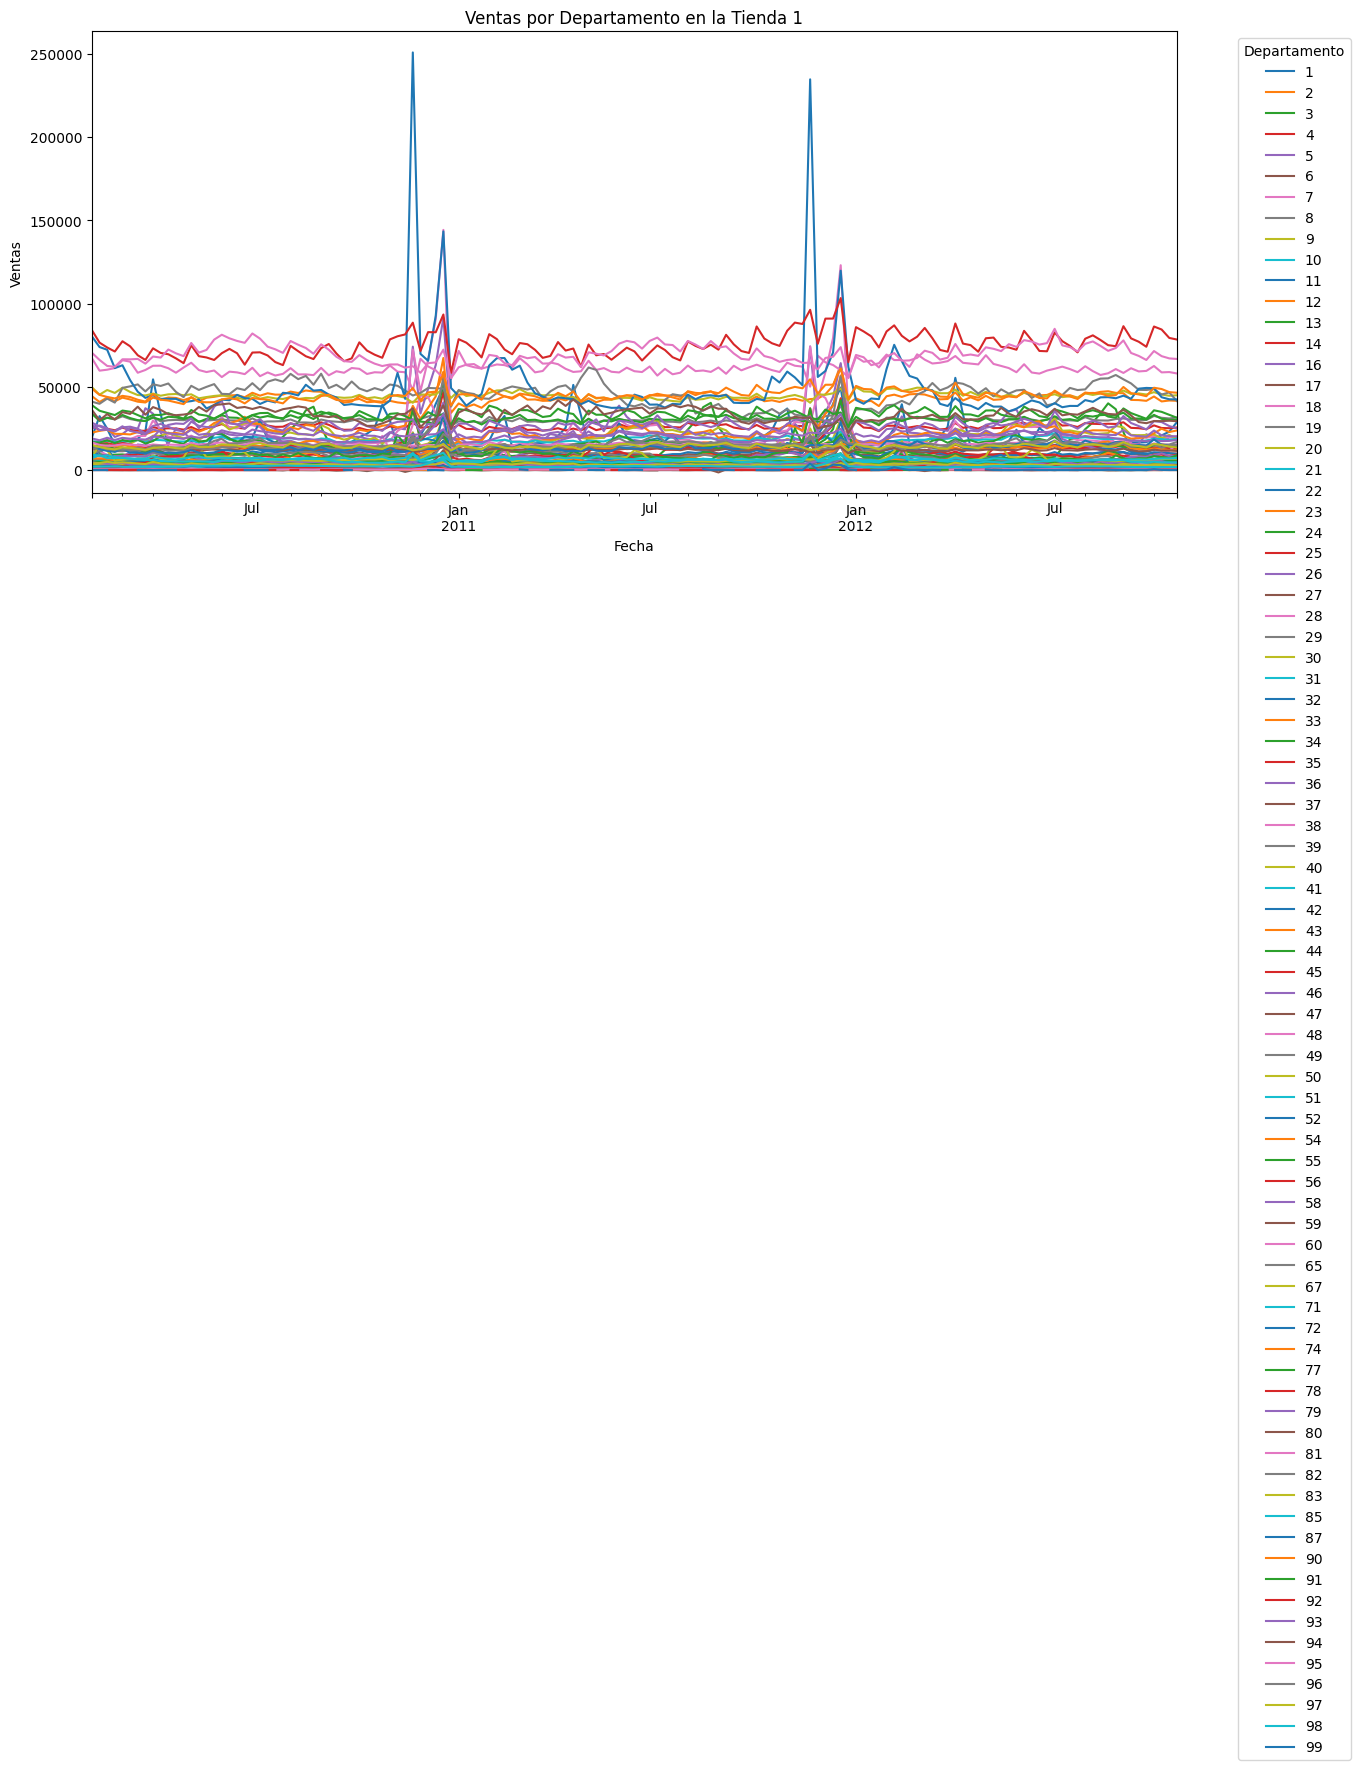

In [146]:
# Seleccionar una tienda (por ejemplo, Tienda 1)
store_id = 1  # Cambia al ID de la tienda que desees analizar

# Filtrar datos para la tienda seleccionada
df_tienda = train_df.copy()

# Agregar ventas por fecha y departamento
ventas_depto = df_tienda.groupby(['Date', 'Dept'])['Weekly_Sales'].mean().reset_index()

# Crear una tabla pivote para graficar
ventas_depto_pivot = ventas_depto.pivot(index='Date', columns='Dept', values='Weekly_Sales')

# Graficar ventas por departamento
ventas_depto_pivot.plot(figsize=(14,6))
plt.title(f'Ventas por Departamento en la Tienda {store_id}')
plt.xlabel('Fecha')
plt.ylabel('Ventas')
plt.legend(title='Departamento', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


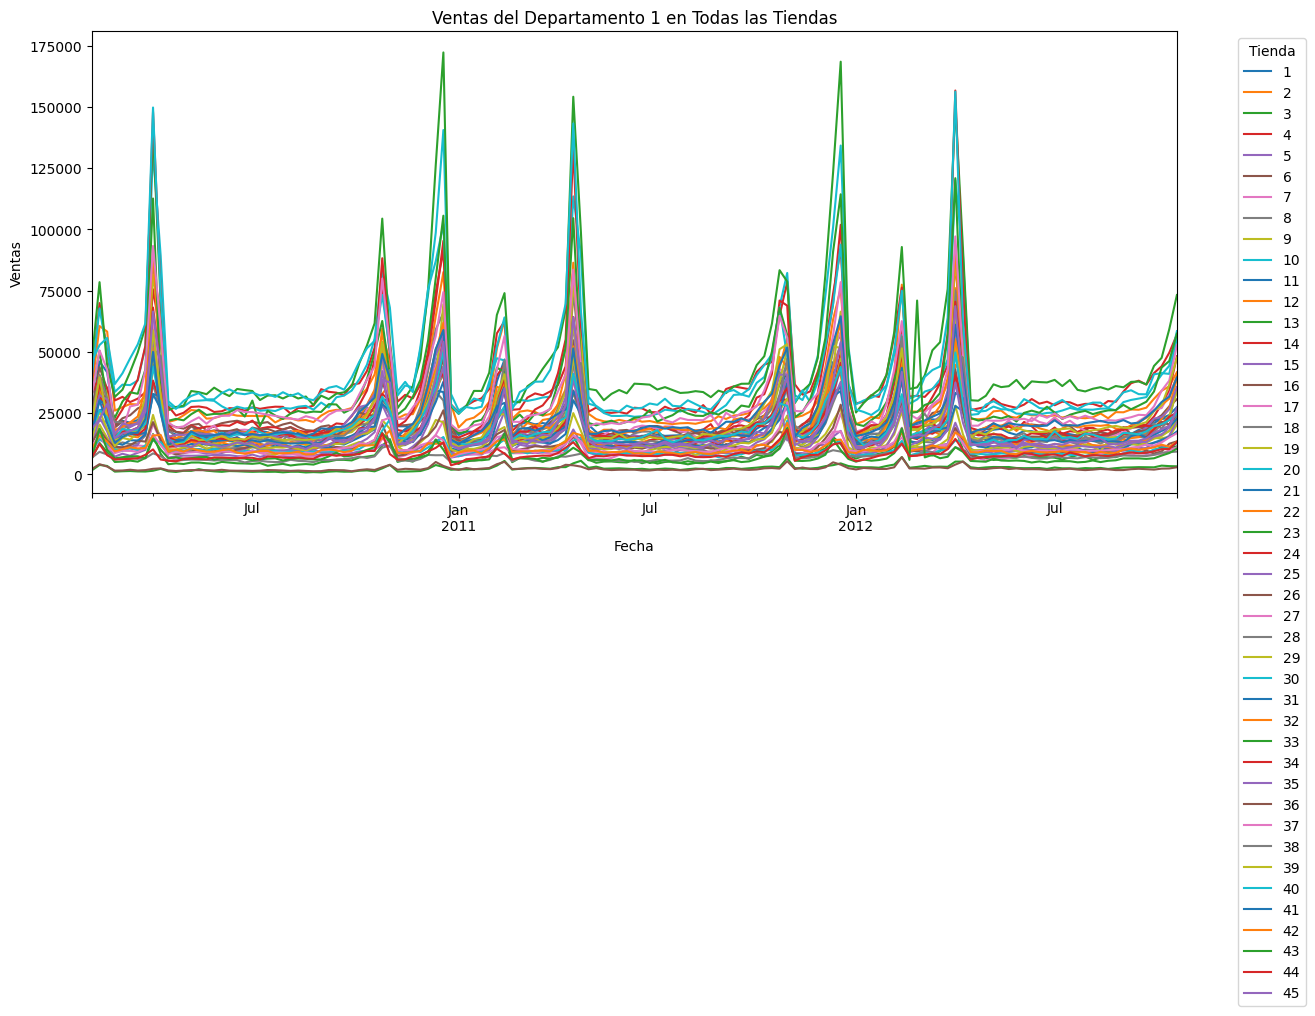

In [147]:
# Seleccionar un departamento (por ejemplo, Departamento 1)
dept_id = 1  # Cambia al ID del departamento que desees analizar

# Filtrar datos para el departamento seleccionado
df_depto = train_df[train_df['Dept'] == dept_id]

# Agregar ventas por fecha y tienda
ventas_depto_tienda = df_depto.groupby(['Date', 'Store'])['Weekly_Sales'].sum().reset_index()

# Crear una tabla pivote para graficar
ventas_depto_tienda_pivot = ventas_depto_tienda.pivot(index='Date', columns='Store', values='Weekly_Sales')

# Graficar ventas del departamento en todas las tiendas
ventas_depto_tienda_pivot.plot(figsize=(14,6))
plt.title(f'Ventas del Departamento {dept_id} en Todas las Tiendas')
plt.xlabel('Fecha')
plt.ylabel('Ventas')
plt.legend(title='Tienda', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


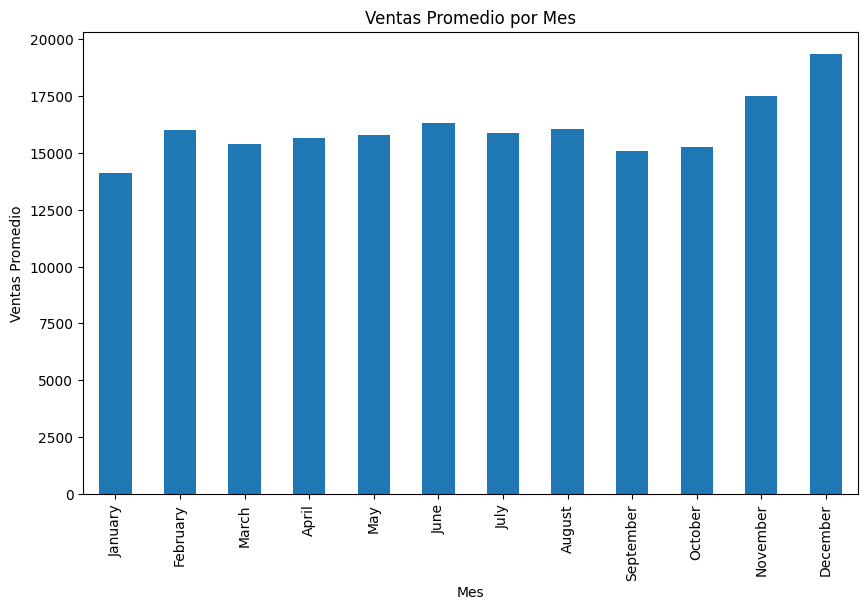

In [148]:
# Añadir columna con el mes
train_df['Mes'] = train_df['Date'].dt.month_name()

# Calcular ventas promedio por mes
ventas_mes = train_df.groupby('Mes')['Weekly_Sales'].mean().reindex(['January', 'February', 'March', 'April', 'May', 'June',
                                                       'July', 'August', 'September', 'October', 'November', 'December'])

# Graficar ventas promedio por mes
ventas_mes.plot(kind='bar', figsize=(10,6))
plt.title('Ventas Promedio por Mes')
plt.xlabel('Mes')
plt.ylabel('Ventas Promedio')
plt.show()


In [181]:
import re
import warnings
from typing import List, Optional, Tuple

import numpy as np
import pandas as pd
from pandas.api.types import is_numeric_dtype
from pandas.tseries import offsets
from pandas.tseries.frequencies import to_offset


# adapted from gluonts
def time_features_from_frequency_str(freq_str: str) -> List[str]:
    """
    Returns a list of time features that will be appropriate for the given frequency string.

    Parameters
    ----------

    freq_str
        Frequency string of the form [multiple][granularity] such as "12H", "5min", "1D" etc.

    """

    features_by_offsets = {
        offsets.YearBegin: [],
        offsets.YearEnd: [],
        offsets.MonthBegin: [
            "Month",
            "Quarter",
            "Is_quarter_end",
            "Is_quarter_start",
            "Is_year_end",
            "Is_year_start",
        ],
        offsets.MonthEnd: [
            "Month",
            "Quarter",
            "Is_quarter_end",
            "Is_quarter_start",
            "Is_year_end",
            "Is_year_start",
        ],
        offsets.Week: [
            "Month",
            "Quarter",
            "Is_quarter_end",
            "Is_quarter_start",
            "Is_year_end",
            "Is_year_start",
            "Is_month_start",
            "Week",
        ],
        offsets.Day: [
            "Month",
            "Quarter",
            "Is_quarter_end",
            "Is_quarter_start",
            "Is_year_end",
            "Is_year_start",
            "Is_month_start",
            "Week" "Day",
            "Dayofweek",
            "Dayofyear",
        ],
        offsets.BusinessDay: [
            "Month",
            "Quarter",
            "Is_quarter_end",
            "Is_quarter_start",
            "Is_year_end",
            "Is_year_start",
            "Is_month_start",
            "Week" "Day",
            "Dayofweek",
            "Dayofyear",
        ],
        offsets.Hour: [
            "Month",
            "Quarter",
            "Is_quarter_end",
            "Is_quarter_start",
            "Is_year_end",
            "Is_year_start",
            "Is_month_start",
            "Week" "Day",
            "Dayofweek",
            "Dayofyear",
            "Hour",
        ],
        offsets.Minute: [
            "Month",
            "Quarter",
            "Is_quarter_end",
            "Is_quarter_start",
            "Is_year_end",
            "Is_year_start",
            "Is_month_start",
            "Week" "Day",
            "Dayofweek",
            "Dayofyear",
            "Hour",
            "Minute",
        ],
    }

    offset = to_offset(freq_str)

    for offset_type, feature in features_by_offsets.items():
        if isinstance(offset, offset_type):
            return feature

    supported_freq_msg = f"""
    Unsupported frequency {freq_str}

    The following frequencies are supported:

        Y, YS   - yearly
            alias: A
        M, MS   - monthly
        W   - weekly
        D   - daily
        B   - business days
        H   - hourly
        T   - minutely
            alias: min
    """
    raise RuntimeError(supported_freq_msg)


# adapted from fastai
@classmethod
def make_date(df: pd.DataFrame, date_field: str):
    "Make sure `df[date_field]` is of the right date type."
    field_dtype = df[date_field].dtype
    if isinstance(field_dtype, pd.core.dtypes.dtypes.DatetimeTZDtype):
        field_dtype = np.datetime64
    if not np.issubdtype(field_dtype, np.datetime64):
        df[date_field] = pd.to_datetime(df[date_field], infer_datetime_format=True)
    return df


# adapted from fastai
def add_temporal_features(
    df: pd.DataFrame,
    field_name: str,
    frequency: str,
    add_elapsed: bool = True,
    prefix: str = None,
    drop: bool = True,
    use_32_bit: bool = False,
) -> Tuple[pd.DataFrame, List]:
    """Adds columns relevant to a date in the column `field_name` of `df`.

    Args:
        df (pd.DataFrame): Dataframe to which the features need to be added
        field_name (str): The date column which should be encoded using temporal features
        frequency (str): The frequency of the date column so that only relevant features are added.
            If frequency is "Weekly", then temporal features like hour, minutes, etc. doesn't make sense.
        add_elapsed (bool, optional): Add time elapsed as a monotonically increasing function. Defaults to True.
        prefix (str, optional): Prefix to the newly created columns. If left None, will use the field name. Defaults to None.
        drop (bool, optional): Flag to drop the data column after feature creation. Defaults to True.
        use_32_bit (bool, optional): Flag to use float32 or int32 to reduce memory. Defaults to False.

    Returns:
        Tuple[pd.DataFrame, List]: Returns a tuple of the new dataframe and a list of features which were added
    """
    field = df[field_name]
    prefix = (re.sub("[Dd]ate$", "", field_name) if prefix is None else prefix) + "_"
    attr = time_features_from_frequency_str(frequency)
    _32_bit_dtype = "int32"
    added_features = []
    for n in attr:
        if n == "Week":
            continue
        df[prefix + n] = (
            getattr(field.dt, n.lower()).astype(_32_bit_dtype)
            if use_32_bit
            else getattr(field.dt, n.lower())
        )
        added_features.append(prefix + n)
    # Pandas removed `dt.week` in v1.1.10
    if "Week" in attr:
        week = (
            field.dt.isocalendar().week
            if hasattr(field.dt, "isocalendar")
            else field.dt.week
        )
        df.insert(
            3, prefix + "Week", week.astype(_32_bit_dtype) if use_32_bit else week
        )
        added_features.append(prefix + "Week")
    if drop:
        df.drop(field_name, axis=1, inplace=True)
    return df, added_features


def _calculate_fourier_terms(
    seasonal_cycle: np.ndarray, max_cycle: int, n_fourier_terms: int
):
    """Calculates Fourier Terms given the seasonal cycle and max_cycle"""
    sin_X = np.empty((len(seasonal_cycle), n_fourier_terms), dtype="float64")
    cos_X = np.empty((len(seasonal_cycle), n_fourier_terms), dtype="float64")
    for i in range(1, n_fourier_terms + 1):
        sin_X[:, i - 1] = np.sin((2 * np.pi * seasonal_cycle * i) / max_cycle)
        cos_X[:, i - 1] = np.cos((2 * np.pi * seasonal_cycle * i) / max_cycle)
    return np.hstack([sin_X, cos_X])


def add_fourier_features(
    df: pd.DataFrame,
    column_to_encode: str,
    max_value: Optional[int] = None,
    n_fourier_terms: int = 1,
    use_32_bit: bool = False,
) -> Tuple[pd.DataFrame, List]:
    """Adds Fourier Terms for the specified seasonal cycle column, like month, week, hour, etc.

    Args:
        df (pd.DataFrame): The dataframe which has the seasonal cyycles which has to be encoded
        column_to_encode (str): The column name which has the seasonal cycle
        max_value (int): The maximum value the seasonal cycle can attain. for eg. for month, max_value is 12.
            If not given, it will be inferred from the data, but if the data does not have at least a
            single full cycle, the inferred max value will not be appropriate. Defaults to None
        n_fourier_terms (int): Number of fourier terms to be added. Defaults to 1
        use_32_bit (bool, optional): Flag to use float32 or int32 to reduce memory. Defaults to False.
    Raises:
        warnings.warn: Raises a warning if max_value is None

    Returns:
        [Tuple[pd.DataFrame, List]]: Returns a tuple of the new dataframe and a list of features which were added
    """
    assert (
        column_to_encode in df.columns
    ), "`column_to_encode` should be a valid column name in the dataframe"
    assert is_numeric_dtype(
        df[column_to_encode]
    ), "`column_to_encode` should have numeric values."
    if max_value is None:
        max_value = df[column_to_encode].max()
        raise warnings.warn(
            "Inferring max cycle as {} from the data. This may not be accuracte if data is less than a single seasonal cycle."
        )
    fourier_features = _calculate_fourier_terms(
        df[column_to_encode].astype(int).values,
        max_cycle=max_value,
        n_fourier_terms=n_fourier_terms,
    )
    feature_names = [
        f"{column_to_encode}_sin_{i}" for i in range(1, n_fourier_terms + 1)
    ] + [f"{column_to_encode}_cos_{i}" for i in range(1, n_fourier_terms + 1)]
    df[feature_names] = fourier_features
    if use_32_bit:
        df[feature_names] = df[feature_names].astype("float32")
    return df, feature_names


def bulk_add_fourier_features(
    df: pd.DataFrame,
    columns_to_encode: List[str],
    max_values: List[int],
    n_fourier_terms: int = 1,
    use_32_bit: bool = False,
) -> Tuple[pd.DataFrame, List]:
    """Adds Fourier Terms for all the specified seasonal cycle columns, like month, week, hour, etc.

    Args:
        df (pd.DataFrame): The dataframe which has the seasonal cyycles which has to be encoded
        columns_to_encode (List[str]): The column names which has the seasonal cycle
        max_values (List[int]): The list of maximum values the seasonal cycles can attain in the
            same order as the columns to encode. for eg. for month, max_value is 12.
            If not given, it will be inferred from the data, but if the data does not have at least a
            single full cycle, the inferred max value will not be appropriate. Defaults to None
        n_fourier_terms (int): Number of fourier terms to be added. Defaults to 1
        use_32_bit (bool, optional): Flag to use float32 or int32 to reduce memory. Defaults to False.
    Raises:
        warnings.warn: Raises a warning if max_value is None

    Returns:
        [Tuple[pd.DataFrame, List]]: Returns a tuple of the new dataframe and a list of features which were added
    """
    assert len(columns_to_encode) == len(
        max_values
    ), "`columns_to_encode` and `max_values` should be of same length."
    added_features = []
    for column_to_encode, max_value in zip(columns_to_encode, max_values):
        df, features = add_fourier_features(
            df,
            column_to_encode,
            max_value,
            n_fourier_terms=n_fourier_terms,
            use_32_bit=use_32_bit,
        )
        added_features += features
    return df, added_features


In [179]:
def drop_unnused_Store_Dept_combinations(train_df, test_df):
    ''' 
    hay combinaciones de tiendas y departamentos que no tienen ventas, y 
    ademas no existen en el dataset de test, así que no tiene sentido usarlos en el train"
    '''
    train_df_copy = train_df.copy()
    test_df_copy = test_df.copy()
    train_df_copy['Store_Dept'] = train_df_copy['Store'].astype(str) + '_' + train_df_copy['Dept'].astype(str)
    test_df_copy['Store_Dept'] = test_df_copy['Store'].astype(str) + '_' + test_df_copy['Dept'].astype(str)
    test_unique_Store_Dept = test_df_copy["Store_Dept"].unique()
    return train_df_copy[train_df_copy["Store_Dept"].isin(test_unique_Store_Dept)].drop("Store_Dept", axis=1)

In [180]:
# Crear una columna combinada 'Store_Dept'
drop_unnused_Store_Dept_combinations(train_df, test_df)

,Store,Dept,Date,Weekly_Sales,IsHoliday,Mes
0,1,1,2010-02-05,24924.50,False,February
1,1,1,2010-02-12,46039.49,True,February
2,1,1,2010-02-19,41595.55,False,February
3,1,1,2010-02-26,19403.54,False,February
4,1,1,2010-03-05,21827.90,False,March
...,...,...,...,...,...,...
421565,45,98,2012-09-28,508.37,False,September
421566,45,98,2012-10-05,628.10,False,October
421567,45,98,2012-10-12,1061.02,False,October
421568,45,98,2012-10-19,760.01,False,October


In [152]:
train_unique_Store_Deptn = train_df["Store_Dept"].unique()
train_unique_Store_Deptn.__len__()

3331

In [161]:

test_unique_Store_Dept.__len__()

3169

In [162]:
train_df = 

In [92]:
# train_df["difference"] = train_df["Weekly_Sales"] - train_df["Weekly_Sales"].shift(1)

In [93]:
sales_pivot = train_df.pivot_table(index='Date', columns='Store', values="Weekly_Sales", aggfunc='mean')

In [94]:
sales_pivot.isna().sum().sum()

np.int64(0)

In [113]:
sales_pivot_diff = (sales_pivot.shift(1) - sales_pivot)

In [114]:
sales_pivot_diff.dropna(inplace=True)

In [115]:
# from sklearn.impute import SimpleImputer

# # Imputar valores NaN con la media de la matriz de distancias
# imputer = SimpleImputer(strategy='mean')
# sales_pivot_imputed = imputer.fit_transform(sales_pivot)

In [116]:
# sales_pivot = sales_pivot.interpolate(method='linear', axis=0)

In [117]:
from tslearn.utils import to_time_series_dataset

# Convertir sales_pivot a numpy array
sales_array = sales_pivot_diff.T.values  # Transponer para que cada serie sea una fila

# Asegurarse de que no haya valores NaN
sales_array = np.nan_to_num(sales_array)

# Convertir al formato requerido por tslearn
time_series_dataset = to_time_series_dataset(sales_array)


In [118]:
# from sklearn.impute import SimpleImputer

# # Imputar valores NaN con la media de la matriz de distancias
# imputer = SimpleImputer(strategy='mean')
# sales_pivot_imputed = imputer.fit_transform(sales_pivot)

In [119]:
# from sklearn.preprocessing import MinMaxScaler

# # Normalizar cada serie temporal individualmente
# scaler = MinMaxScaler()
# sales_pivot_normalized = scaler.fit_transform(sales_pivot_imputed.T)  # Transponer para aplicar a cada serie por separado


In [120]:
# from sklearn.preprocessing import StandardScaler

# # Estandarizar cada serie temporal
# scaler = StandardScaler()
# sales_pivot_standardized = scaler.fit_transform(sales_pivot_imputed.T)


In [121]:
# from dtaidistance import dtw
# from sklearn.cluster import AgglomerativeClustering

# n_clusters=3
# # Calcular la matriz de distancias DTW
# distance_matrix = dtw.distance_matrix_fast(sales_pivot_standardized)

# # Aplicar clustering (ejemplo con clustering jerárquico)
# clustering = AgglomerativeClustering(n_clusters=n_clusters, metric='precomputed', linkage='average')
# labels = clustering.fit_predict(distance_matrix)
# cluster_labels = pd.DataFrame({'Dept': sales_pivot.columns , 'Cluster': labels})

# print(cluster_labels.head())

In [122]:
# import numpy as np

# # Aplicar la transformada de Fourier a cada serie
# sales_fft = np.fft.fft(sales_pivot_standardized, axis=1)

# # Tomar solo las primeras componentes (las más importantes en términos de frecuencia)
# sales_fft_abs = np.abs(sales_fft[:, :10])

# # Aplicar clustering sobre estas componentes de frecuencia
# from sklearn.cluster import KMeans

# kmeans = KMeans(n_clusters=n_clusters)
# labels = kmeans.fit_predict(sales_fft_abs)
# cluster_labels = pd.DataFrame({'Dept': sales_pivot.columns , 'Cluster': labels})

# print(cluster_labels.head())

In [123]:
# from tslearn.clustering import KShape

# # Ajustar el modelo K-Shape (n_clusters: número de clusters deseado)
# ks = KShape(n_clusters=n_clusters, random_state=0)
# labels = ks.fit_predict(sales_pivot_standardized)
# cluster_labels = pd.DataFrame({'Dept': sales_pivot.columns , 'Cluster': labels})

# print(cluster_labels.head())

In [124]:
# from scipy.spatial.distance import pdist, squareform
# from sklearn.cluster import AgglomerativeClustering

# # Calcular la matriz de distancias basada en correlación inversa (1 - correlación)
# correlation_matrix = np.corrcoef(sales_pivot_standardized)
# distance_matrix = 1 - correlation_matrix

# # Aplicar clustering
# clustering = AgglomerativeClustering(n_clusters=n_clusters, metric='precomputed', linkage='average')
# labels = clustering.fit_predict(distance_matrix)
# # Añadir las etiquetas de cluster a tus datos
# cluster_labels = pd.DataFrame({'Dept': sales_pivot.columns , 'Cluster': labels})

# print(cluster_labels.head())

In [125]:
# # Interpolar valores faltantes
# sales_pivot.interpolate(method='linear', inplace=True)

# # O rellenar con ceros
# # sales_pivot.fillna(0, inplace=True)

# # Opcional: Eliminar columnas con más del 50% de datos faltantes
# threshold = int(0.5 * len(sales_pivot))
# sales_pivot.dropna(axis=1, thresh=threshold, inplace=True)

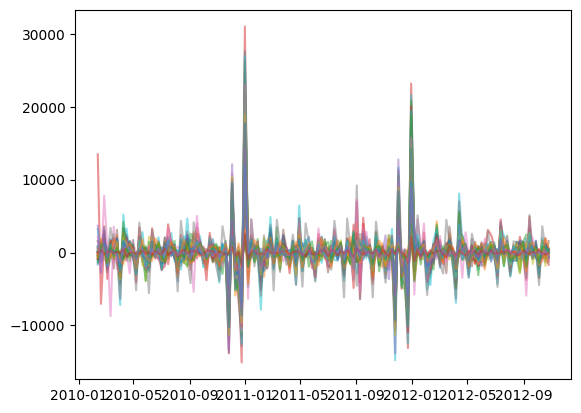

In [126]:
plt.plot(sales_pivot_diff, alpha=0.5);

In [127]:
# from tsfresh import extract_features

# # Reiniciar el índice de sales_pivot
# sales_reset = sales_pivot.reset_index()

# # Convertir el DataFrame de formato ancho a largo
# sales_long = sales_reset.melt(id_vars=['Date'], var_name='Store_Dept', value_name='Sales')

# # Añadir una columna de tiempo
# sales_long['time'] = sales_long['Date'].astype(int) / 10**9  # Convertir a timestamp en segundos

# # Extraer características
# extracted_features = extract_features(sales_long, column_id='Store_Dept', column_sort='time', column_value='Sales')

# # Verificar las características extraídas
# print(extracted_features.head())


In [128]:
from tslearn.clustering import TimeSeriesKMeans

# Definir el número de clusters (debes elegir un valor apropiado)
n_clusters = 2

# Configurar el modelo
model = TimeSeriesKMeans(n_clusters=n_clusters, metric="dtw", max_iter=10, random_state=42)

# Entrenar el modelo
labels = model.fit_predict(time_series_dataset)

# Añadir las etiquetas de cluster a tus datos
cluster_labels = pd.DataFrame({'Store': sales_pivot.columns, 'Cluster': labels})

print(cluster_labels.head())


   Store  Cluster
0      1        0
1      2        0
2      3        1
3      4        0
4      5        1


In [129]:
cluster_labels.groupby("Cluster").count()

,Store
Cluster,
0,19
1,26


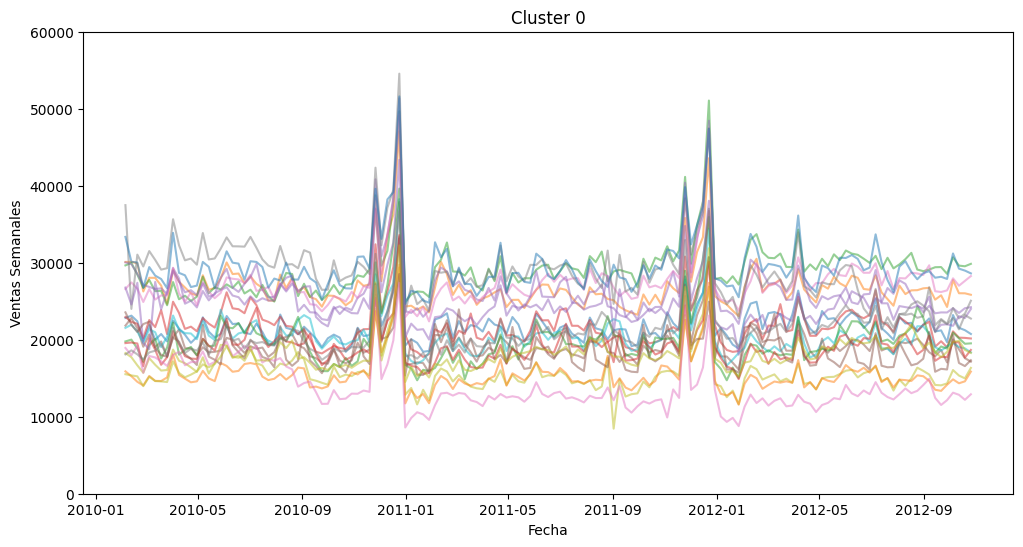

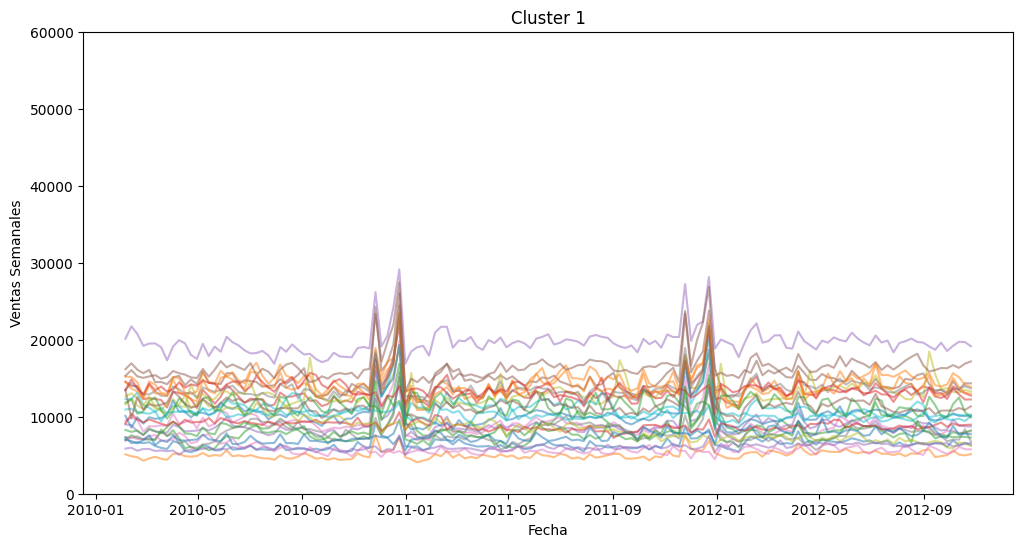

In [130]:
import matplotlib.pyplot as plt

for cluster_num in range(n_clusters):
    plt.figure(figsize=(12,6))
    cluster_members = cluster_labels[cluster_labels['Cluster'] == cluster_num]['Store']
    for member in cluster_members:
        plt.plot(sales_pivot.index, sales_pivot[member], alpha=0.5)
    plt.title(f'Cluster {cluster_num}')
    plt.xlabel('Fecha')
    plt.ylabel('Ventas Semanales')
    plt.ylim(0, 60000)
    plt.show()
